In [ ]:
pip install scattertext emoji unidecode

In [ ]:
import sys, string, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scattertext as st
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import nltk, spacy
from nltk.stem import WordNetLemmatizer
import emoji
import unidecode
from lib.plot_helper import *

nltk.download(['averaged_perceptron_tagger', 'stopwords', 'punkt'])
nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words('english')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1) E-Commerce Review

## 1.1 Pre-processing

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def text_replace_series(series):
    series = series.str.replace("(<br/>)", "")
    series = series.str.replace('(<a).*(>).*(</a>)', '')
    series = series.str.replace('(&amp)', '')
    series = series.str.replace('(&gt)', '')
    series = series.str.replace('(&lt)', '')
    series = series.str.replace('(\xa0)', ' ')
    return series

def preprocess_text(text, token=True):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = unidecode.unidecode(text)
    text = [t.lower() for t in text.split() if len(t) > 0]
    text = [ch.lower() for ch in text
            if ch.isalpha() or ch == '.' or emoji.get_emoji_regexp().search(ch)]

    text = [t for t in text if t not in stop_words]
    text = [t.lemma_ for t in nlp(' '.join(text))]
    # text = [wordnet_lemmatizer.lemmatize(t) for t in text]

    # Join the characters again to form the string.
    if token == False:
        text = ' '.join(text)

    return text

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/NadimKawwa/WomeneCommerce/master/Womens%20Clothing%20E-Commerce%20Reviews.csv')
df['Review Text'] = df['Review Text'].astype(str)
df['Review Text'] = text_replace_series(df['Review Text'])
df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Review Text'].apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,polarity,review_len,word_count
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.633333,53,8
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0.339583,303,62
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675,500,98
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000,124,22
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891,192,36


In [ ]:
# negative reviews
df.sort_values('polarity').head()['Review Text'].values

array(['Cut out design, no seems or hems.\r\n very disappointed in retailer',
       'Received this product with a gaping hole in it. very disappointed in the quality and the quality control at the warehouse',
       'Awful color, horribly wrinkled and just a mess...so disappointed',
       "What a disappointment and for the price, it's outrageous!",
       'The button fell off when i took it out of the bag, and i noticed that all of the thread had unraveled. will be returning :-('],
      dtype=object)

In [ ]:
# positive reviews
df.sort_values('polarity').tail()['Review Text'].values

array(['This is the perfect holiday dress. my best purchase of the season!',
       'Beautiful dress! the pics online do not do any justice! i got compliments all day!',
       'Perfect for lunch with the girls, pta, or saturdays with the family. this skirt is a perfect addition to your fall wardrobe.',
       'This is a wonderful style.',
       "Absolutely gorgeous!\r\nwords can't describe the beauty of this dress!\r\ni hope they will restock it cause i would order size s (didn't know how it runs)."],
      dtype=object)

In [ ]:
# word counts, removed stop words
vectorizer = CountVectorizer(stop_words = 'english', min_df=10)
bag_of_words = vectorizer.fit_transform(df['Review Text'].astype(str))
words_freq = pd.DataFrame(
    bag_of_words.toarray(),
    columns=dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])).keys())
words_freq = words_freq.sum(axis=0).sort_values(ascending=False).to_dict()
df_freq = pd.DataFrame(words_freq.items(), columns = ['ReviewText' , 'count'])
df_freq.head()

,ReviewText,count
0,dress,10567
1,love,8951
2,size,8772
3,fit,7325
4,like,7149


In [ ]:
# bigram counts, removed stop words
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(2, 2), min_df=10)
bag_of_words = vectorizer.fit_transform(df['Review Text'].astype(str))
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
df_bi_freq = pd.DataFrame(words_freq, columns = ['ReviewText' , 'count'])
df_bi_freq.head()

,ReviewText,count
0,true size,1347
1,love dress,766
2,usually wear,691
3,looks great,620
4,fit perfectly,609


## 1.2 Association

In [ ]:
corpus = st.CorpusFromPandas(df.sample(1000), category_col='Department Name', text_col='Review Text', nlp=nlp).build()

In [ ]:
# the terms that differentiate the review text from a general English corpus.
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['nan', 'flowy', 'pilcro', 'flattering', 'slouchy', 'boxy', 'xxs', 'xxsp', 'peplum', 'frumpy']


In [ ]:
# review text that are most associated with the Tops department
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Tops Score'] = corpus.get_scaled_f_scores('Tops')
print(list(term_freq_df.sort_values(by='Tops Score', ascending=False).index[:10]))

['this top', 'this shirt', 'shirt', 'sweater', 'top', 'top is', 'this sweater', 'blouse', 'the shirt', 'white']


## 1.3 Plot

In [ ]:
get_histrogram(df['polarity'], title='Sentiment Polarity Distribution', bins=50)

Most of the review sentiments are positive

In [ ]:
get_histrogram(df['Rating'], ytitle='Count', title='Review Rating Distribution', bins=None)

The ratings are in align with the polarity score, that is, most of the ratings are pretty high at 4 or 5 ranges.

In [ ]:
get_histrogram(df['review_len'], title='Review length', bins=100)

In [ ]:
get_histrogram(df['word_count'], title='Review Text Word Count Distribution', bins=100)

In [ ]:
df_x = df.groupby('Class Name').count()['Clothing ID'].sort_values(ascending=False).index
df_y= df.groupby('Class Name').count()['Clothing ID'].sort_values(ascending=False).values
get_bar(df_x, df_y, xtitle='Class Name', title='Bar chart of Class Name')

In [ ]:
get_bar(df_freq['ReviewText'].head(20),
        df_freq['count'].head(20),
        xtitle='Class Name',
        title='Top 20 words in review after removing stop words')

In [ ]:
get_bar(df_bi_freq['ReviewText'].head(20),
        df_bi_freq['count'].head(20),
        xtitle='Class Name',
        title='Top 20 Bigrams in review after removing stop words')

In [ ]:
blob = TextBlob(str(df['Review Text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word', 'pos'])

get_bar(pos_df.pos.value_counts().index,
        pos_df.pos.value_counts(),
        xtitle='Class Name',
        title='Top 20 Part-of-speech tagging for review corpus')

In [ ]:
get_boxplot_cat(df, 'Department Name', 'polarity', title='Sentiment Polarity Boxplot of Department Name')

In [ ]:
get_boxplot_cat(df, 'Department Name', 'review_len', title='Sentiment Polarity Boxplot of Department Name')

In [ ]:
get_histrogram_bi(df, 'Recommended IND', 'polarity', bins=100)

In [ ]:
get_histrogram_bi(df, 'Recommended IND', 'Rating', mode = 'group',)

In [ ]:
get_histrogram_bi(df, 'Recommended IND', 'review_len', mode = 'group', title='Distribution of Review Lengths Based on Recommendation')

In [ ]:
# get_joint_plot(df['polarity'], df['Rating'], x_name=None, y_name=None)

In [ ]:
# get_joint_plot(df['Age'], df['polarity'], x_name=None, y_name=None)

## 1.4 Topic Modelling

LSA, which stands for Latent Semantic Analysis, is one of the foundational techniques used in topic modeling.



In [ ]:
reindexed_data = df['Review Text'].dropna().values
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [ ]:
# 6 topic, with assigned probabilities to each vocab
lsa_model.components_.shape

(6, 13856)

In [ ]:
# lsa_topic_matrix comprise of 6 probabilties (of 6 topics) for 22641 documents
# lsa_keys contains the topic each document belong to
# lsa_dict stores the total number of documents of each topics
lsa_keys = lsa_topic_matrix.argmax(axis=1).tolist()
lsa_dict = {a : b for a, b in sorted(Counter(lsa_keys).items())}

print(lsa_topic_matrix.shape)
print(lsa_keys[:5])
print(lsa_dict)

(23486, 6)
[3, 1, 1, 3, 5]
{0: 845, 1: 20557, 2: 862, 3: 548, 4: 105, 5: 569}


In [ ]:
# users got to dedice the topic name
top_3_words = {}
for index, topic in enumerate(lsa_model.components_):
    print(f'THE TOP 3 WORDS FOR TOPIC #{index}')
    top_words = [tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-3:]]
    print(top_words)
    top_3_words[index] = ' '.join(top_words)

THE TOP 3 WORDS FOR TOPIC #0
['size', 'jeans', 'nan']
THE TOP 3 WORDS FOR TOPIC #1
['size', 'love', 'dress']
THE TOP 3 WORDS FOR TOPIC #2
['slip', 'beautiful', 'dress']
THE TOP 3 WORDS FOR TOPIC #3
['comfortable', 'love', 'great']
THE TOP 3 WORDS FOR TOPIC #4
['great', 'small', 'size']
THE TOP 3 WORDS FOR TOPIC #5
['small', 'cute', 'shirt']


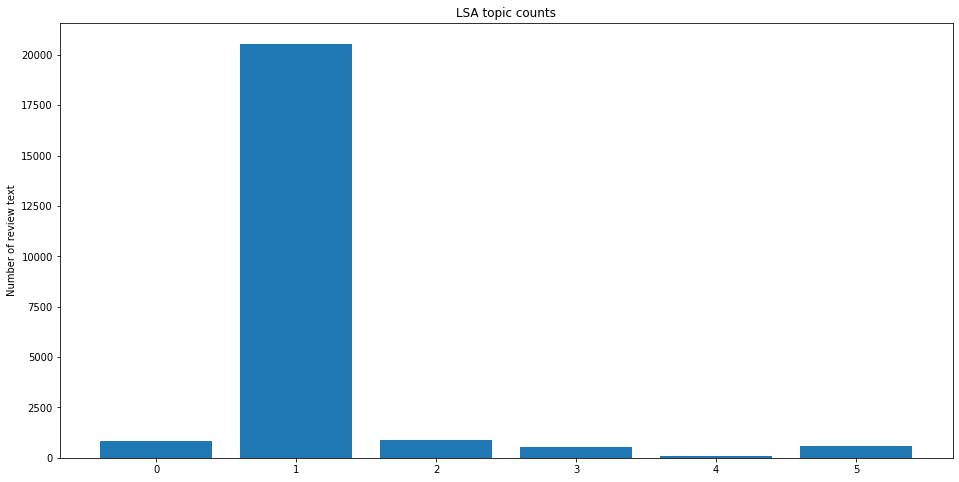

In [ ]:
labels = [f'Topic {a}: {b}' for a, b in top_3_words.items()]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_dict.keys(), lsa_dict.values());
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

By looking at the most frequent words in each topic, we have a sense that we may not reach any degree of separation across the topic categories. In another word, we could not separate review text by departments using topic modeling techniques.